# Classificação de imagens Sentinel 2 com Multilayer Perceptron

Remover warnings desnecessarios

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os

pp = papiro_path = "./drive/MyDrive/ColabNotebooks/ClassImg" # no meu caso

# Work arround pra montar pastas "Shared with me"
# go to Google Drive, right click on the folder in question, and then click "Add shortcut to Drive".

os.listdir(pp)

['S2',
 'S2_cutted',
 'Prints',
 'S2_AOI_nuvens',
 'k_means.gtif',
 'Classification_CNN_S2.ipynb',
 'Clustering_KMeans-S2.ipynb',
 'S2_area6_cutted',
 'S2_area8_cutted',
 'S2_area9_cutted',
 'Classification_MLP_S2_P2.ipynb',
 'Classification_MLP_S2.ipynb']

In [ ]:
import numpy as np
import random as rd
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from osgeo import gdal, gdal_array
from scipy.signal import convolve2d
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score

## Dataset

(1385, 1393)
(1929305, 1)
(1385, 1393)
(1929305, 1)


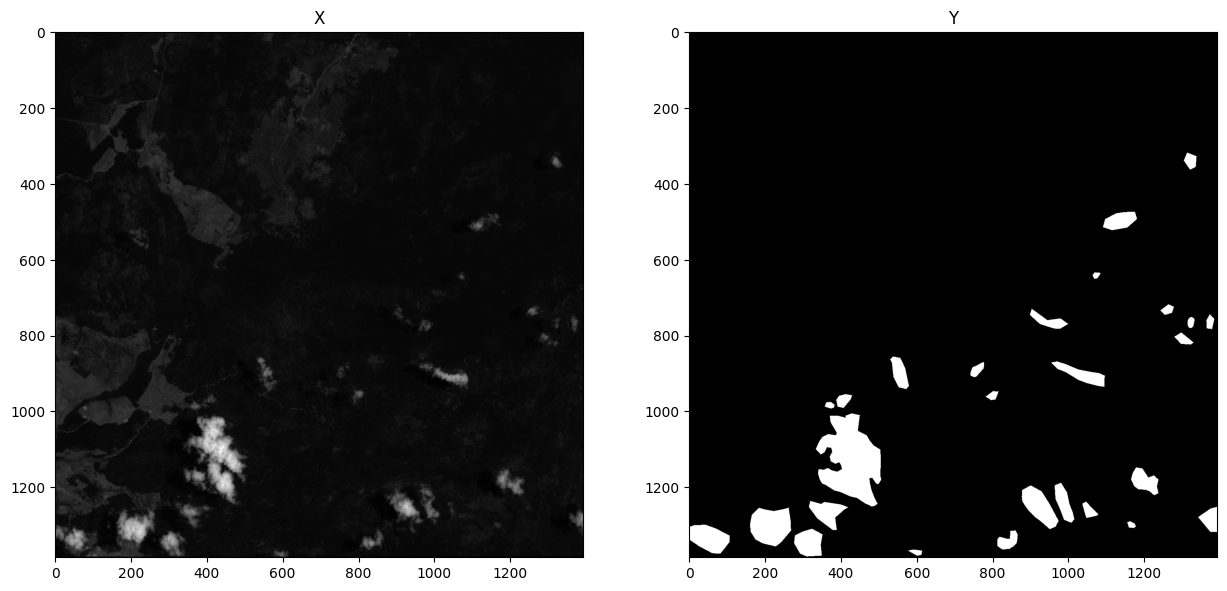

In [ ]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in raster image
img_filename = 'S2B_tile_20190401_20NQH_0_B04.tif'  # SRC: 32620 , UTM/20N (m)
img_ds = gdal.Open(os.path.join(pp,'S2_cutted',img_filename), gdal.GA_ReadOnly)

#band = img_ds.GetRasterBand(2)
#img = band.ReadAsArray()

img = img_ds.ReadAsArray()
print (img.shape)

X = img.reshape((-1,1))
print (X.shape)

# Same for nuvens raster:
# Read in raster image
nuvens_ds = gdal.Open(os.path.join(pp,'S2_AOI_nuvens','nuvens.tif'), gdal.GA_ReadOnly)

#band = img_ds.GetRasterBand(2)
#img = band.ReadAsArray()

nuvens = nuvens_ds.ReadAsArray()
print (nuvens.shape)

Y = nuvens.reshape((-1,1))
print (Y.shape)

# plot dataset sample and objective
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
ax1.set_title("X")
ax1.imshow(img, cmap=plt.get_cmap("gray"))
ax2.set_title("Y")
ax2.imshow(nuvens, cmap=plt.get_cmap("gray"))

plt.show()

In [ ]:
img.shape

(1385, 1393)

In [ ]:
"""j=0
for k in range(0,img.shape[0]):
  for i in range(0,img.shape[1]):
    j+=1
aux = np.zeros((60,60,j))
j =0
for i in range(0,img.shape[0]-59):
  for k in range(0,img.shape[1]-59):
    print(i,k,img[i:i+60,k:k+60].shape)
    aux[:,:,j] = img[i:i+60,k:k+60]
    j+=1
j-=1
j"""

'j=0\nfor k in range(0,img.shape[0]):\n  for i in range(0,img.shape[1]):\n    j+=1\naux = np.zeros((60,60,j))\nj =0\nfor i in range(0,img.shape[0]-59):\n  for k in range(0,img.shape[1]-59):\n    print(i,k,img[i:i+60,k:k+60].shape)\n    aux[:,:,j] = img[i:i+60,k:k+60]\n    j+=1\nj-=1\nj'

## Normalizando o vetor de entrada

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X) # Compute min/max to be used for later scaling. See scaler.data_max_
X_Inputs = scaler.transform(X) # Fit to data, then transform it.
print(min(X),"-",max(X), end=" --> ")
print(min(X_Inputs),"-",max(X_Inputs))

[0] - [10312] --> [0.] - [1.]


## Salvar o scaler

In [ ]:
import pickle

# save the model to a file
with open('minmax_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
# load the model from the file
"""with open('minmax_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)"""

"with open('minmax_scaler.pkl', 'rb') as f:\n    scaler = pickle.load(f)"

## Separação dos dados

In [ ]:
def my_split(x,y):
  # Do not go random, just use last data to train model
  x_test  = x.reshape(img.shape)[254:842,1000:-1]
  y_test  = y.reshape(img.shape)[254:842,1000:-1]
  print("x_test",x_test.shape)
  x_train = x.reshape(img.shape)[700:1240,290:]
  y_train = y.reshape(img.shape)[700:1240,290:]
  print("x_train",x_train.shape)
  x_val  = x.reshape(img.shape)[1241:1385,:]
  y_val  = y.reshape(img.shape)[1241:1385,:]
  return x_train, x_test, y_train, y_test, x_val, y_val


In [ ]:
a,b, c,d, e,f = my_split(X_Inputs, Y)

x_test (588, 392)
x_train (540, 1103)


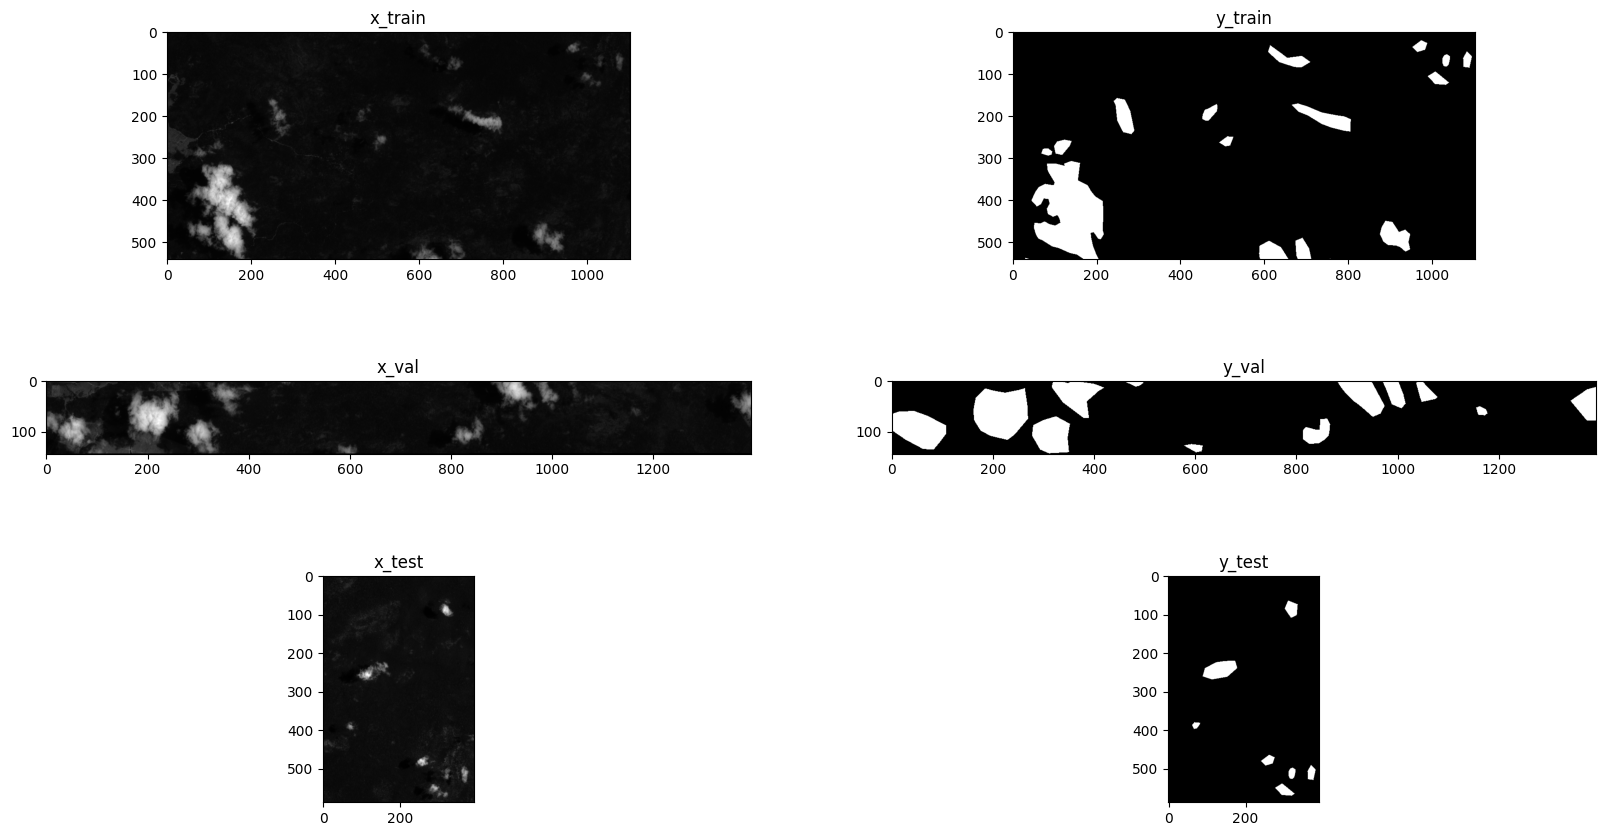

In [ ]:

# plot dataset sample and objective
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(20,10))
ax1.set_title("x_train")
ax1.imshow(a, cmap=plt.get_cmap("gray"))
ax2.set_title("y_train")
ax2.imshow(c, cmap=plt.get_cmap("gray"))

ax3.set_title("x_val")
ax3.imshow(e, cmap=plt.get_cmap("gray"))
ax4.set_title("y_val")
ax4.imshow(f, cmap=plt.get_cmap("gray"))

ax5.set_title("x_test")
ax5.imshow(b, cmap=plt.get_cmap("gray"))
ax6.set_title("y_test")
ax6.imshow(d, cmap=plt.get_cmap("gray"))

plt.show()

Shape de X (1929305, 1)
Shape de Y (1929305, 1)
Shape de x_train (595620, 1)
Shape de x_val (200592, 1)
Shape de x_test (230496, 1)
Shape de y_train (595620, 1)
Shape de y_val (200592, 1)
Shape de y_test (230496, 1)


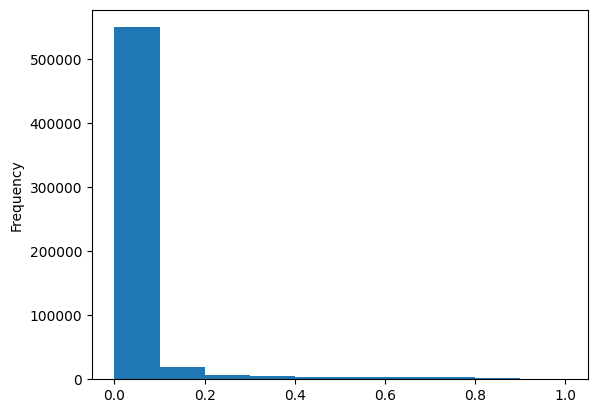

In [ ]:
"""x_train, x_test, y_train, y_test = train_test_split(X_Inputs, Y, test_size=0.2) # np
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)"""

x_train, x_test, y_train, y_test, x_val, y_val = a.reshape(-1,1), b.reshape(-1,1), c.reshape(-1,1), d.reshape(-1,1), e.reshape(-1,1), f.reshape(-1,1)

"""unique, counts = np.unique(x_train, return_counts=True)
print(dict(zip(unique, counts)))"""

print('Shape de X', X.shape)
print('Shape de Y', Y.shape)

print('Shape de x_train', x_train.shape)
print('Shape de x_val', x_val.shape)
print('Shape de x_test', x_test.shape)
print('Shape de y_train', y_train.shape)
print('Shape de y_val', y_val.shape)
print('Shape de y_test', y_test.shape)

pd.Series(x_train.reshape(x_train.shape[0])).plot.hist()
plt.show()

In [ ]:
# convert class vectors to binary class matrices ----- WHY?
num_classes = 2
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Importando os módulos do Keras necessários: model e layers
# Sequential
# tf.keras.optimizers.RMSprop

# Criando um modelo Sequential e adicionando as camadas
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(512, activation='relu', input_shape=(x_train.shape[1],)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu')) # new
#model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               1024      
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 527,362
Trainable params: 527,362
Non-tr

In [ ]:
print('Shape de x_train', x_train.shape)
print('Shape de x_val', x_val.shape)
print('Shape de x_test', x_test.shape)
print('Shape de y_train', y_train.shape)
print('Shape de y_val', y_val.shape)
print('Shape de y_test', y_test.shape)

Shape de x_train (595620, 1)
Shape de x_val (200592, 1)
Shape de x_test (230496, 1)
Shape de y_train (595620, 2)
Shape de y_val (200592, 2)
Shape de y_test (230496, 2)


In [ ]:
%%time
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
              metrics=['accuracy'])

bs = 400
epochs = 30
UpdateCallback = tf.keras.callbacks.EarlyStopping(
                                                    monitor='loss',
                                                    min_delta=0.01,
                                                    patience=5,
                                                    verbose=0,
                                                    mode='auto',
                                                    baseline=None,
                                                    restore_best_weights=False,
                                                    start_from_epoch=0
                                                )

# This callback will stop the training when there is no improvement in the loss for three consecutive epochs. 47s --> 2,8s
history = model.fit(x_train, y_train, epochs=epochs,batch_size=bs, verbose=2, callbacks=[], validation_data=(x_val, y_val))


Epoch 1/30
1490/1490 - 7s - loss: 0.0984 - accuracy: 0.9688 - val_loss: 0.3017 - val_accuracy: 0.9131 - 7s/epoch - 5ms/step
Epoch 2/30
1490/1490 - 6s - loss: 0.0968 - accuracy: 0.9690 - val_loss: 0.2722 - val_accuracy: 0.9152 - 6s/epoch - 4ms/step
Epoch 3/30
1490/1490 - 6s - loss: 0.0971 - accuracy: 0.9688 - val_loss: 0.2717 - val_accuracy: 0.9135 - 6s/epoch - 4ms/step
Epoch 4/30
1490/1490 - 6s - loss: 0.0966 - accuracy: 0.9690 - val_loss: 0.2970 - val_accuracy: 0.9176 - 6s/epoch - 4ms/step
Epoch 5/30
1490/1490 - 5s - loss: 0.0967 - accuracy: 0.9689 - val_loss: 0.2715 - val_accuracy: 0.9020 - 5s/epoch - 4ms/step
Epoch 6/30
1490/1490 - 6s - loss: 0.0967 - accuracy: 0.9687 - val_loss: 0.2163 - val_accuracy: 0.9166 - 6s/epoch - 4ms/step
Epoch 7/30
1490/1490 - 5s - loss: 0.0967 - accuracy: 0.9688 - val_loss: 0.2377 - val_accuracy: 0.9186 - 5s/epoch - 4ms/step
Epoch 8/30
1490/1490 - 6s - loss: 0.0966 - accuracy: 0.9688 - val_loss: 0.2567 - val_accuracy: 0.9185 - 6s/epoch - 4ms/step
Epoch 9/

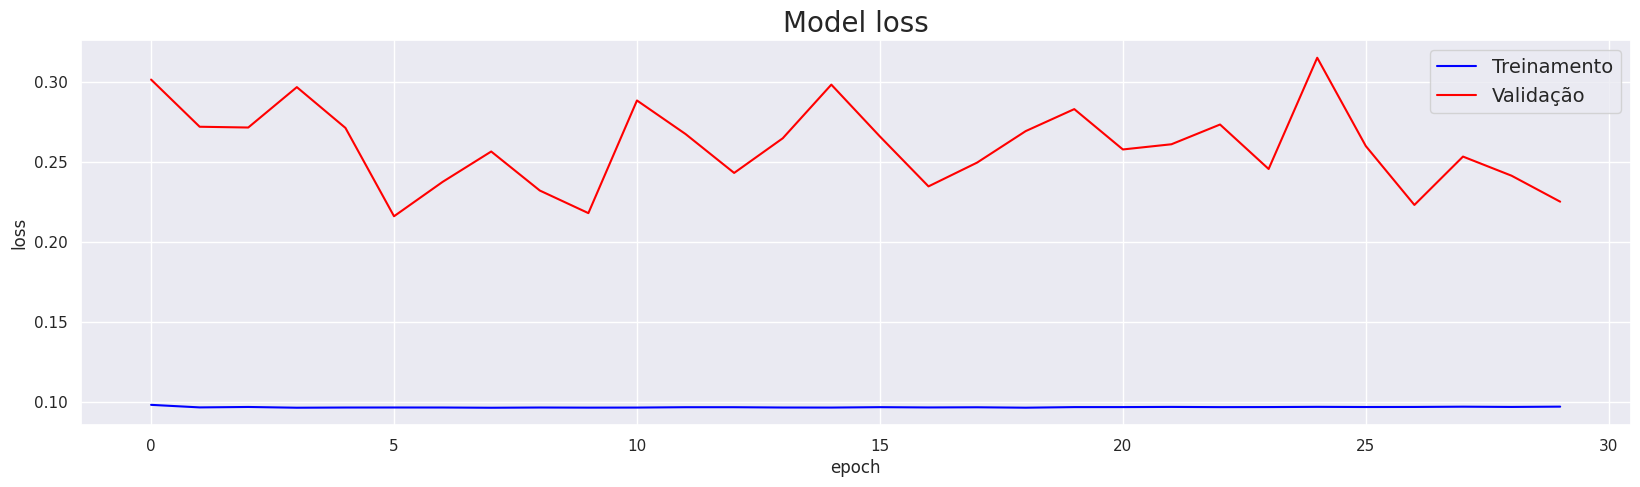

In [ ]:
# Plotando o historico do processo de treinamento
plt.figure(figsize=(20, 5))
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='red')
plt.title('Model loss', fontsize=20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Treinamento', 'Validação'], loc='upper right', fontsize=14)
plt.show()

In [ ]:
#
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06425895541906357
Test accuracy: 0.9780603647232056


In [ ]:
fn = 'modelo_%.5f_%.5f.keras' %(score[0],score[1])
fn

'modelo_0.06426_0.97806.keras'

In [ ]:
#model.save(os.path.join(pp,'S2_AOI_nuvens',fn))

## If in hurry, start from the latest model:

In [ ]:
loaded_model = tf.keras.models.load_model(os.path.join(pp,'S2_AOI_nuvens','modelo_0.06426_0.97806.keras'))#'modelo_%.5f_%.5f.keras' %(score[0],score[1])))

## Plot Y_pred

In [ ]:
Y_full_pred = loaded_model.predict(X_Inputs)

60291/60291 [==============================] - 131s 2ms/step


In [ ]:
int_Y_full_pred = [x.argmax() for x in Y_full_pred]
int_Y_full = [x.argmax() for x in tf.keras.utils.to_categorical(Y, 2)]

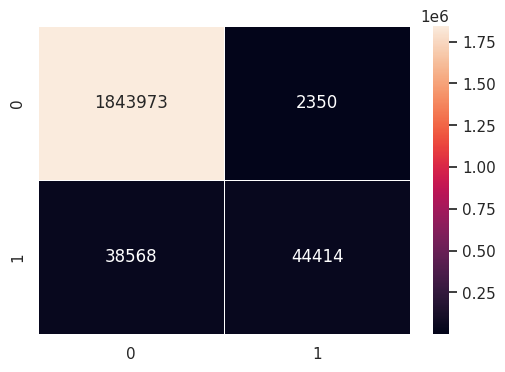

In [ ]:
sns.set_theme()
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(confusion_matrix(int_Y_full, int_Y_full_pred), annot=True, fmt="d", linewidths=.5, ax=ax)
plt.show()

In [ ]:
print(classification_report(int_Y_full, int_Y_full_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1846323
           1       0.95      0.54      0.68     82982

    accuracy                           0.98   1929305
   macro avg       0.96      0.77      0.84   1929305
weighted avg       0.98      0.98      0.98   1929305



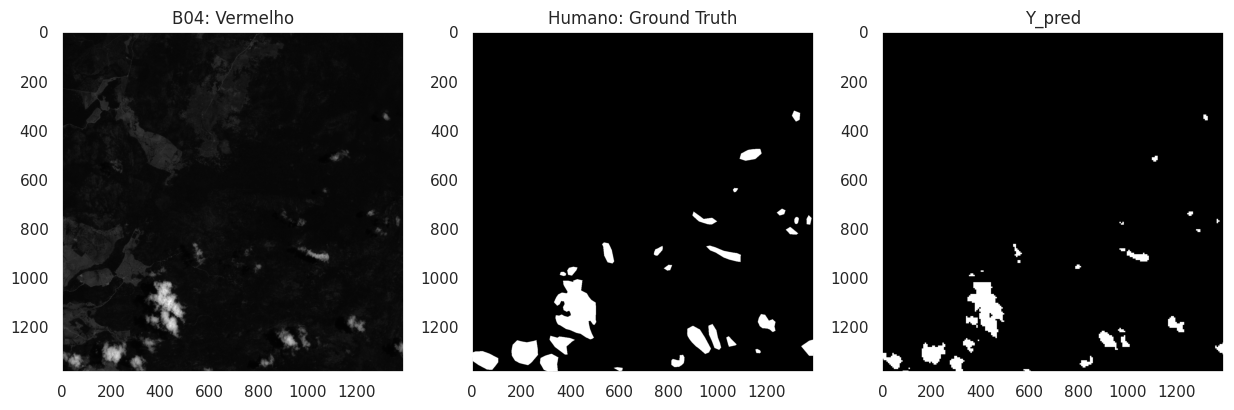

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,15))
ax1.set_title("B04: Vermelho")
ax1.imshow(img, cmap=plt.get_cmap("gray"))
ax1.grid(False)
ax2.set_title("Humano: Ground Truth")
ax2.imshow(nuvens, cmap=plt.get_cmap("gray"))
ax2.grid(False)
ax3.set_title("Y_pred")
ax3.imshow(np.array(int_Y_full_pred).reshape(img.shape), cmap=plt.get_cmap("gray"))
ax3.grid(False)
plt.show()

## It works for another bands?


S2B_tile_20190401_20NQH_0_B01.tif
60291/60291 [==============================] - 95s 2ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1846323
           1       0.95      0.54      0.68     82982

    accuracy                           0.98   1929305
   macro avg       0.96      0.77      0.84   1929305
weighted avg       0.98      0.98      0.98   1929305



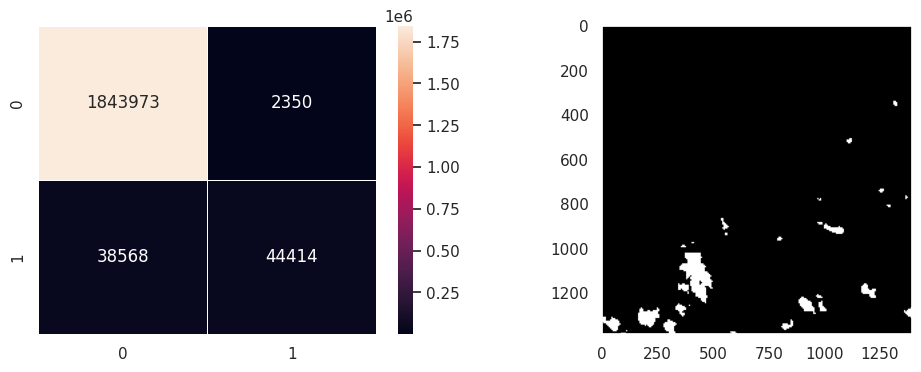


S2B_tile_20190401_20NQH_0_B02.tif
60291/60291 [==============================] - 102s 2ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1846323
           1       0.97      0.56      0.71     82982

    accuracy                           0.98   1929305
   macro avg       0.97      0.78      0.85   1929305
weighted avg       0.98      0.98      0.98   1929305



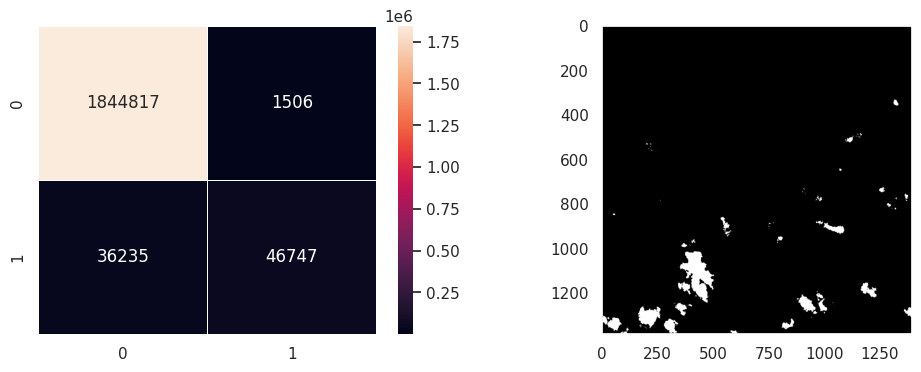


S2B_tile_20190401_20NQH_0_B03.tif
60291/60291 [==============================] - 110s 2ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1846323
           1       0.96      0.58      0.72     82982

    accuracy                           0.98   1929305
   macro avg       0.97      0.79      0.86   1929305
weighted avg       0.98      0.98      0.98   1929305



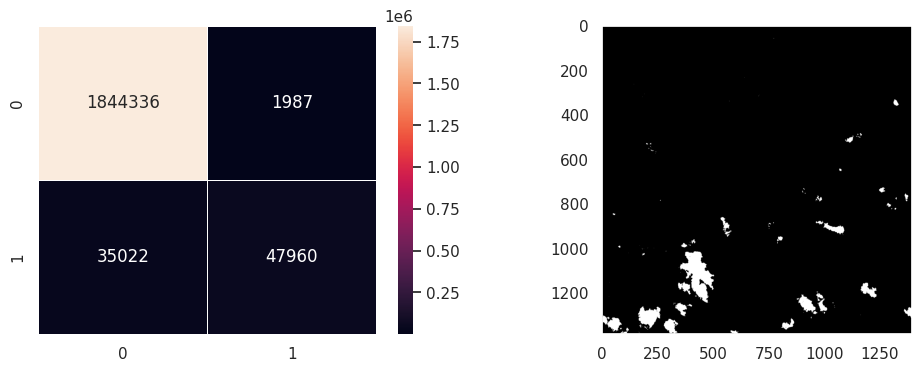


S2B_tile_20190401_20NQH_0_B04.tif
60291/60291 [==============================] - 121s 2ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1846323
           1       0.90      0.56      0.69     82982

    accuracy                           0.98   1929305
   macro avg       0.94      0.78      0.84   1929305
weighted avg       0.98      0.98      0.98   1929305



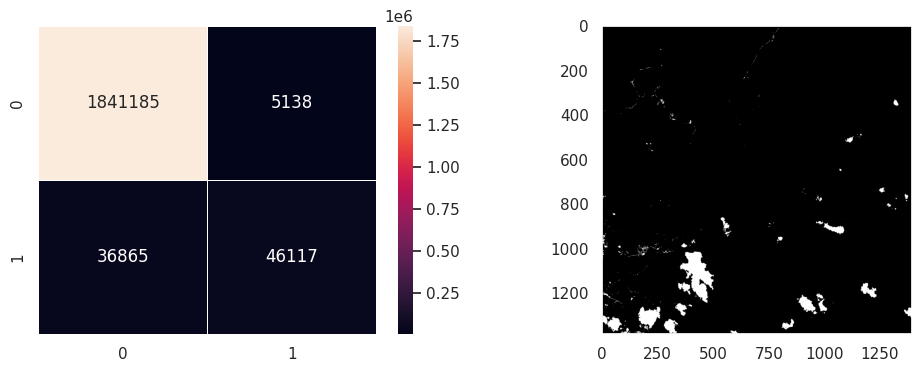


S2B_tile_20190401_20NQH_0_B05.tif
60291/60291 [==============================] - 115s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98   1846323
           1       0.53      0.65      0.59     82982

    accuracy                           0.96   1929305
   macro avg       0.76      0.81      0.78   1929305
weighted avg       0.96      0.96      0.96   1929305



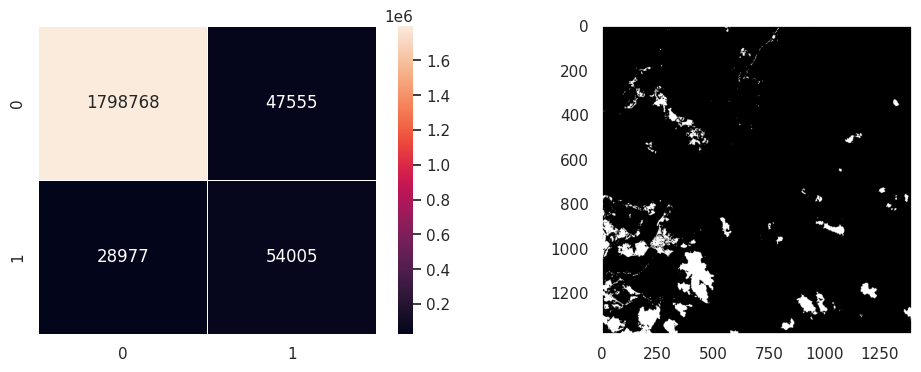


S2B_tile_20190401_20NQH_0_B06.tif
60291/60291 [==============================] - 121s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.14      0.25   1846323
           1       0.05      0.94      0.09     82982

    accuracy                           0.17   1929305
   macro avg       0.51      0.54      0.17   1929305
weighted avg       0.94      0.17      0.24   1929305



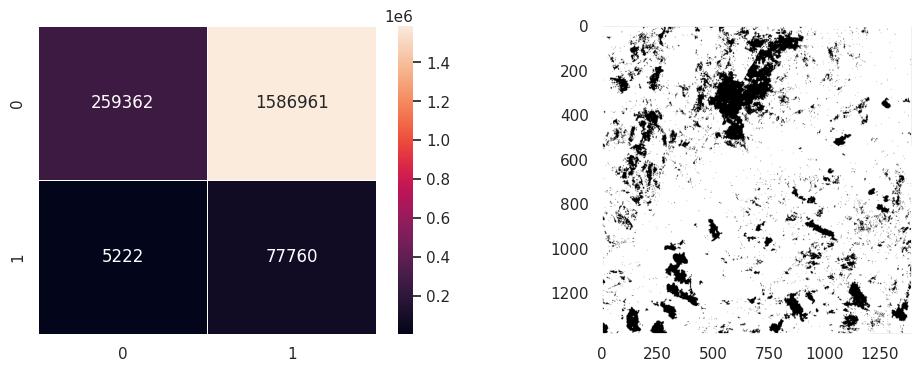


S2B_tile_20190401_20NQH_0_B07.tif
60291/60291 [==============================] - 101s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.07      0.13   1846323
           1       0.04      0.95      0.08     82982

    accuracy                           0.11   1929305
   macro avg       0.51      0.51      0.11   1929305
weighted avg       0.93      0.11      0.13   1929305



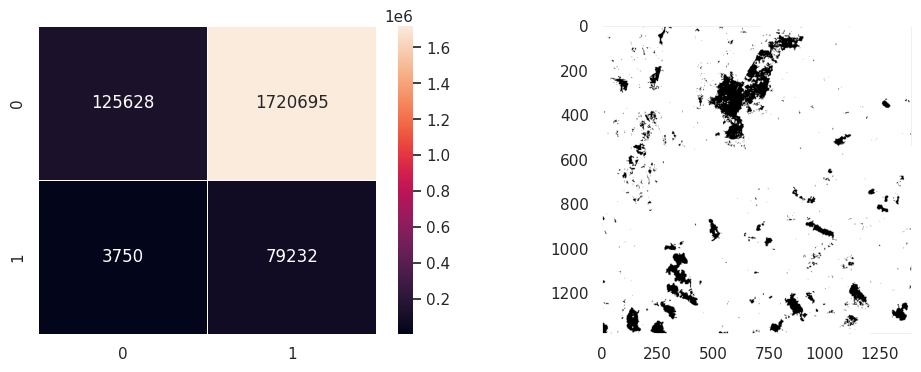


S2B_tile_20190401_20NQH_0_B08.tif
60291/60291 [==============================] - 103s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.07      0.12   1846323
           1       0.04      0.95      0.08     82982

    accuracy                           0.10   1929305
   macro avg       0.51      0.51      0.10   1929305
weighted avg       0.93      0.10      0.12   1929305



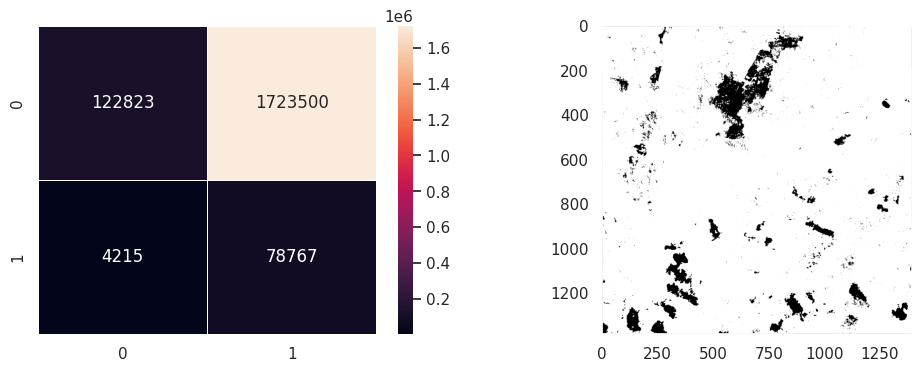


S2B_tile_20190401_20NQH_0_B09.tif
60291/60291 [==============================] - 106s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.05      0.09   1846323
           1       0.04      0.98      0.08     82982

    accuracy                           0.09   1929305
   macro avg       0.51      0.51      0.09   1929305
weighted avg       0.94      0.09      0.09   1929305



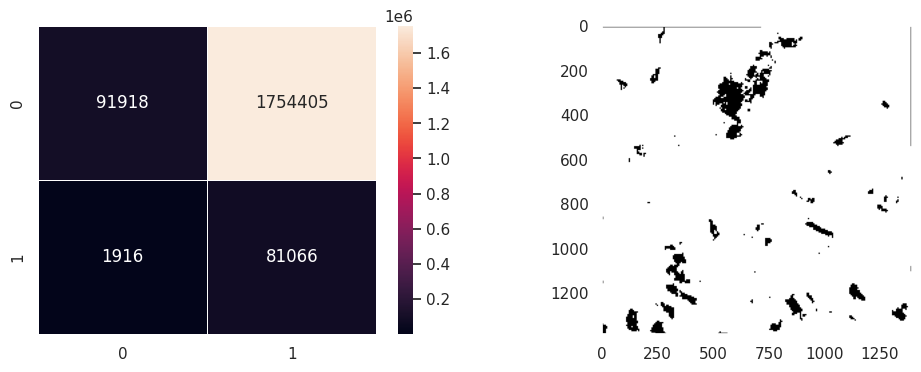


S2B_tile_20190401_20NQH_0_B11.tif
60291/60291 [==============================] - 104s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.68      0.81   1846323
           1       0.11      0.86      0.19     82982

    accuracy                           0.69   1929305
   macro avg       0.55      0.77      0.50   1929305
weighted avg       0.95      0.69      0.78   1929305



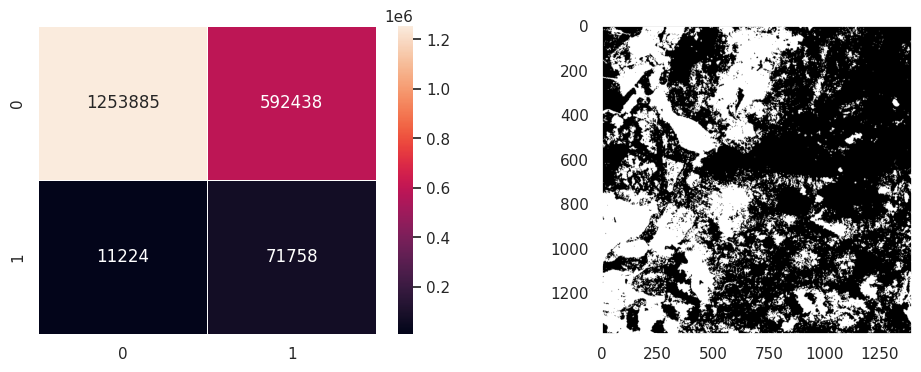


S2B_tile_20190401_20NQH_0_B12.tif
60291/60291 [==============================] - 106s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.93      0.95   1846323
           1       0.26      0.58      0.36     82982

    accuracy                           0.91   1929305
   macro avg       0.62      0.75      0.66   1929305
weighted avg       0.95      0.91      0.93   1929305



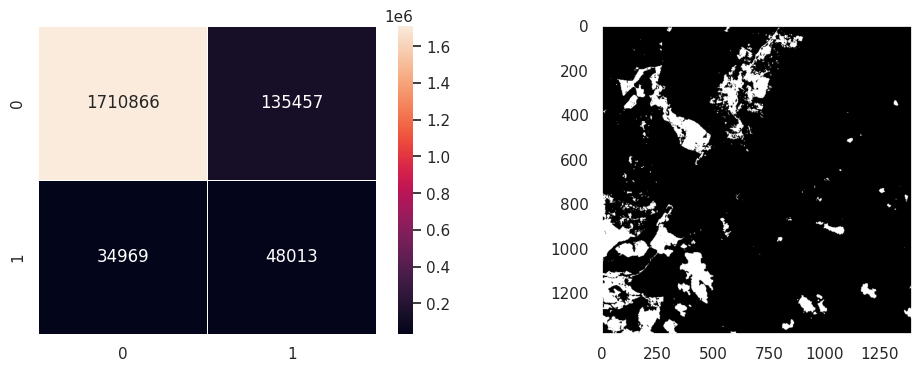


S2B_tile_20190401_20NQH_0_B8A.tif
60291/60291 [==============================] - 109s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.05      0.09   1846323
           1       0.04      0.96      0.08     82982

    accuracy                           0.09   1929305
   macro avg       0.50      0.51      0.09   1929305
weighted avg       0.93      0.09      0.09   1929305



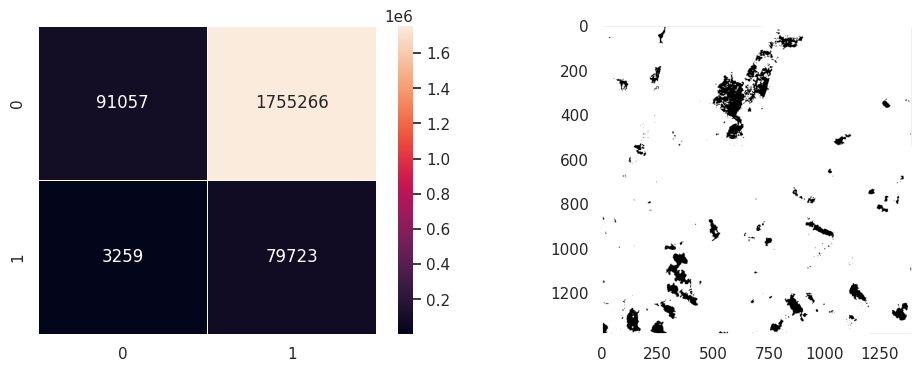

(1385, 1393, 12)
(1929305, 12)
(1929305, 12)


In [ ]:
# Use var from already computed cell to get image size and type
bands = np.zeros((img_ds.RasterYSize,
                  img_ds.RasterXSize,
                  len(os.listdir(os.path.join(pp,'S2_cutted')))
                  ),
                  gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

# Resample bands with smaller shapes (B01= 232,231) (B02= 1393,1385)...
# Done in Preparo no FME

files = []
for i, b in enumerate(sorted(os.listdir(os.path.join(pp,'S2_cutted')))):
  print("")
  print(b)
  f = os.path.join(pp,'S2_cutted',b)
  files.append(b)
  aux_img_ds = gdal.Open(f, gdal.GA_ReadOnly)
  #scaler.fit(aux_img_ds.GetRasterBand(1).ReadAsArray()) # Compute min/max to be used for later scaling. See scaler.data_max_ --> !!!!
  # Não pode fazer um novo fit pq o modelo não saberá como reagir a um escalonamente diferente dos dados
  band = aux_img_ds.GetRasterBand(1).ReadAsArray()
  X_Inputs = scaler.transform(band.reshape(-1,1))
  bands[:, :, i] = X_Inputs.reshape(band.shape)
  Y_full_pred = loaded_model.predict(X_Inputs)
  int_Y_full_pred = [x.argmax() for x in Y_full_pred]

  print(classification_report(int_Y_full, int_Y_full_pred))

  f, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 4))
  sns.heatmap(confusion_matrix(int_Y_full, int_Y_full_pred), annot=True, fmt="d", linewidths=.5, ax=ax1)
  ax2.imshow(np.array(int_Y_full_pred).reshape(img.shape), cmap=plt.get_cmap("gray"))
  ax2.grid(False)
  plt.show()

new_shape = (bands.shape[0] * bands.shape[1], bands.shape[2]) # vetorizar cada banda da imagem
print (bands.shape)
print (new_shape)

X = bands.reshape(new_shape)

print (X.shape)


### Funciona bem para as bandas 1,2,3,4 !


## It works for the same band but for another area cutted from the same original image?

In [ ]:
b04_area_leste   = os.path.join(pp,'S2_area6_cutted','S2B_tile_20190401_20NQH_0_B04.tif')
b04_area_sul     = os.path.join(pp,'S2_area8_cutted','S2B_tile_20190401_20NQH_0_B04.tif')
b04_area_sudeste = os.path.join(pp,'S2_area9_cutted','S2B_tile_20190401_20NQH_0_B04.tif')

rgb_area_leste = os.path.join(pp,'S2_AOI_nuvens','S2B_tile_20190401_20NQH_0_TCI_6.tif')
rgb_area_sul =    os.path.join(pp,'S2_AOI_nuvens','S2B_tile_20190401_20NQH_0_TCI_8.tif')
rgb_area_sudeste = os.path.join(pp,'S2_AOI_nuvens','S2B_tile_20190401_20NQH_0_TCI_9.tif')

In [ ]:
img_leste   = gdal.Open(b04_area_leste, gdal.GA_ReadOnly).ReadAsArray()
img_sul     = gdal.Open(b04_area_sul, gdal.GA_ReadOnly).ReadAsArray()
img_sudeste = gdal.Open(b04_area_sudeste, gdal.GA_ReadOnly).ReadAsArray()

X_leste = scaler.transform(img_leste.reshape((-1,1)))
X_sul = scaler.transform(img_sul.reshape((-1,1)))
X_sudeste = scaler.transform(img_sudeste.reshape((-1,1)))

img_rgb_leste   = gdal.Open(rgb_area_leste, gdal.GA_ReadOnly).ReadAsArray()
img_rgb_sul     = gdal.Open(rgb_area_sul, gdal.GA_ReadOnly).ReadAsArray()
img_rgb_sudeste = gdal.Open(rgb_area_sudeste, gdal.GA_ReadOnly).ReadAsArray()


In [ ]:
Y_leste_pred = loaded_model.predict(X_leste)
int_Y_leste_pred = [x.argmax() for x in Y_leste_pred]
Y_sul_pred = loaded_model.predict(X_sul)
int_Y_sul_pred = [x.argmax() for x in Y_sul_pred]
Y_sudeste_pred = loaded_model.predict(X_sudeste)
int_Y_sudeste_pred = [x.argmax() for x in Y_sudeste_pred]

60291/60291 [==============================] - 109s 2ms/step


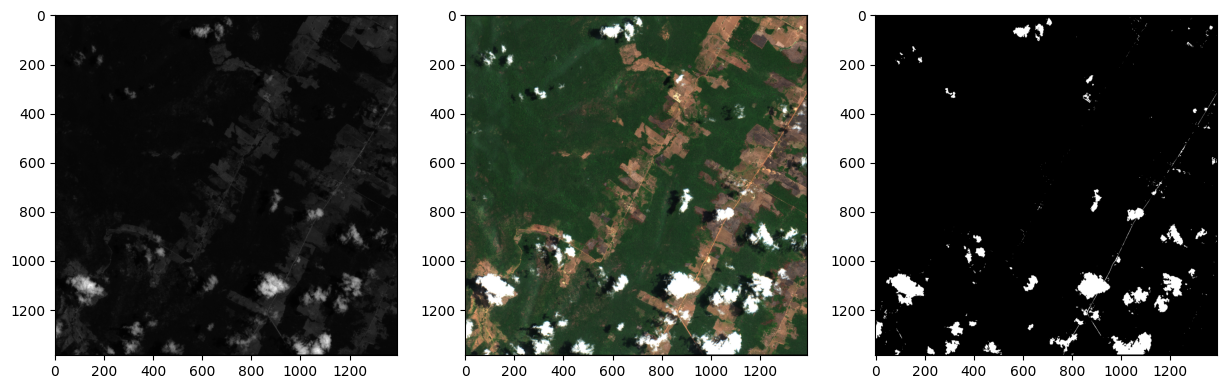

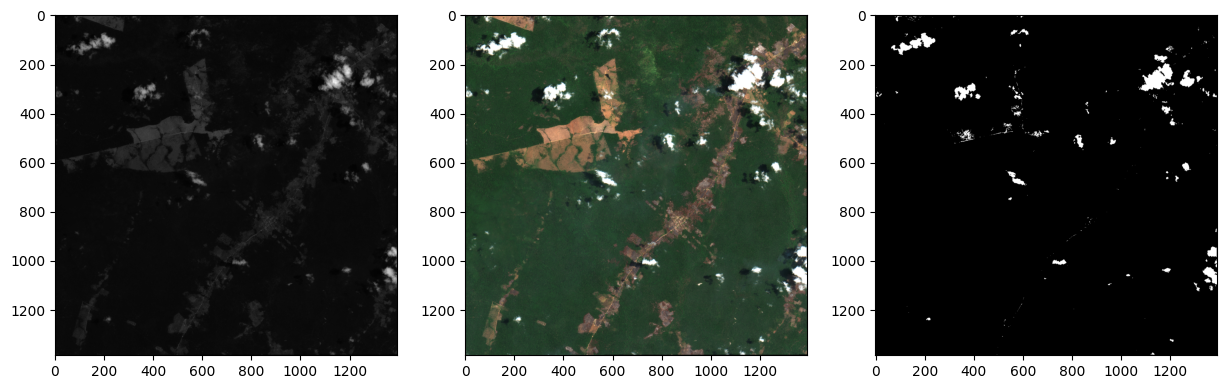

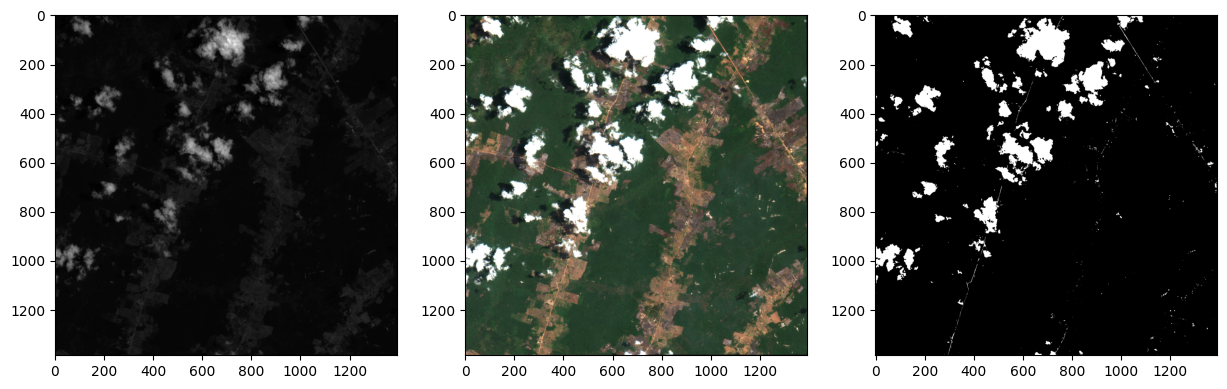

In [ ]:
from sklearn.preprocessing import normalize

# Verificar as 3 bandas do vermelho nas diferentes regiões
color = [ img_rgb_leste[0, :, :], img_rgb_leste[1, :, :], img_rgb_leste[2, :, :]]
color = np.array(color) # this is (3, 1385, 1393)
color = np.swapaxes(color, 2, 0) # this is (1393, 1385, 3)
color = np.swapaxes(color, 1, 0) # this is (1385, 1393, 3)
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15, 15))
ax1.imshow(img_leste, cmap=plt.get_cmap("gray"))
ax2.imshow(color)
ax3.imshow(np.array(int_Y_leste_pred).reshape(img_leste.shape), cmap=plt.get_cmap("gray"))
plt.show()

color2 = [ img_rgb_sul[0, :, :], img_rgb_sul[1, :, :], img_rgb_sul[2, :, :]]
color2 = np.array(color2) # this is (3, 1385, 1393)
color2 = np.swapaxes(color2, 2, 0) # this is (1393, 1385, 3)
color2 = np.swapaxes(color2, 1, 0) # this is (1385, 1393, 3)
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15, 15))
ax1.imshow(img_sul, cmap=plt.get_cmap("gray"))
ax2.imshow(color2, cmap=plt.get_cmap("gray"))
ax3.imshow(np.array(int_Y_sul_pred).reshape(img_sul.shape), cmap=plt.get_cmap("gray"))
plt.show()

color3 = [ img_rgb_sudeste[0, :, :], img_rgb_sudeste[1, :, :], img_rgb_sudeste[2, :, :]]
color3 = np.array(color3) # this is (3, 1385, 1393)
color3 = np.swapaxes(color3, 2, 0) # this is (1393, 1385, 3)
color3 = np.swapaxes(color3, 1, 0) # this is (1385, 1393, 3)
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15, 15))
ax1.imshow(img_sudeste, cmap=plt.get_cmap("gray"))
ax2.imshow(color3, cmap=plt.get_cmap("gray"))
ax3.imshow(np.array(int_Y_sudeste_pred).reshape(img_sudeste.shape), cmap=plt.get_cmap("gray"))
plt.show()

## Lições aprendidas

1. fazer vários modelos. hidden layers diferentes, hiperparâmetros diferentes
2. salvar o modelo_loss_acc_f1score.keras, nome do arquivo com as métricas, inclusive dos dados de teste
3. salvar também o scaler.pkl
4. depois de uma rodada, backup dos melhores resultados